# **XGBoost Training**

In this notebook, we will build upon the baseline model we previously trained using ElasticNet and aim to improve the predictive performance by utilizing the **XGBoost** algorithm. XGBoost is a highly efficient and popular machine learning algorithm that performs well on both structured and unstructured data. Its strength lies in its ability to handle complex, non-linear relationships and its robustness to overfitting when properly tuned.

Also in this case, we will evaluate the model using two different datasets:
1. **Base Dataset**: This dataset contains the original features.
2. **Graph Dataset**: This dataset includes additional features derived from graph-based representations of the data.

For model training and evaluation, we will utilize **TimeSeriesSplit** as our cross-validation technique. This choice ensures that the training and validation sets respect the temporal order of the data.

To optimize the hyperparameters of the XGBoost model, we will use **Optuna**, a powerful hyperparameter optimization framework. Unlike traditional grid search, which exhaustively searches through a predefined set of hyperparameters, Optuna uses a more efficient approach by leveraging a dynamic optimization algorithm to explore the hyperparameter space. This approach is more resource-efficient and can lead to better model performance by finding optimal settings for parameters.

In [1]:
import xgboost as xgb
import optuna
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from pathlib import Path

In [2]:
PROCESSED_PATH = Path("data/processed")
RESULTS_PATH = Path("results")
MODELS_PATH = Path("models")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
MODELS_PATH.mkdir(parents=True, exist_ok=True)

In [3]:
def train_xgboost(dataset_name, df):
    print(f"Training on dataset: {dataset_name}")

    results = {}
    
    target_col = "stop_arrival_delay"
    df = df.sort_values(by=["month", "day_of_week", "hour"])    # Important the order for time series cross-validation
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    tscv = TimeSeriesSplit(n_splits=5)
    
    # Define optimization function for XGBoost
    def objective_xgb_gpu(trial):
        xgb_params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": trial.suggest_float("eta", 0.01, 0.3),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 1),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "seed": 42,
            "tree_method": "hist",
            "device": "cuda",
        }

        rmse_scores = []
        mae_scores = []
        r2_scores = []
        for train_idx, val_idx in tscv.split(X_scaled, y):
            X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = xgb.XGBRegressor(**xgb_params, n_estimators=500, early_stopping_rounds=50)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            preds = model.predict(X_val)

            rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
            mae_scores.append(mean_absolute_error(y_val, preds))
            r2_scores.append(r2_score(y_val, preds))

        return np.mean(rmse_scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective_xgb_gpu, n_trials=50)
    
    print(f"Best parameters for {dataset_name}: {study.best_params}")
    
    # Train final model with best hyperparameters
    best_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=500,
        early_stopping_rounds=50,
        seed=42,
        tree_method="hist",
        device="cuda",
        **study.best_params,
    )
    best_model.fit(X_scaled, y, eval_set=[(X_scaled, y)], verbose=False)

    final_preds = best_model.predict(X_scaled)
    final_rmse = np.sqrt(mean_squared_error(y, final_preds))
    final_mae = mean_absolute_error(y, final_preds)
    final_r2 = r2_score(y, final_preds)
    
    model_filename = MODELS_PATH / f"xgb_{dataset_name.lower()}.pkl"
    results_filename = RESULTS_PATH / f"xgb_results_{dataset_name.lower()}.csv"
    
    with open(model_filename, "wb") as f:
        pickle.dump(best_model, f)
    
    results[dataset_name] = {
        "RMSE": final_rmse,
        "MAE": final_mae,
        "R²": final_r2
    }
    
    pd.DataFrame({
        "RMSE": [final_rmse],
        "MAE": [final_mae],
        "R²": [final_r2]
    }).to_csv(results_filename, index=False)
    
    print(f"Model saved: {model_filename}")
    print(f"Results saved: {results_filename}")
    
    plt.figure(figsize=(10, 5))
    sorted_idx = np.argsort(best_model.feature_importances_)[::-1]
    plt.bar(range(len(X.columns)), best_model.feature_importances_[sorted_idx], align="center")
    plt.xticks(range(len(X.columns)), [X.columns[i] for i in sorted_idx], rotation=90)
    plt.title(f"Feature Importance - {dataset_name}")
    plt.show()

Training on dataset: Base


[I 2025-03-31 06:25:41,215] A new study created in memory with name: no-name-2f81cae2-cdd4-466c-b26f-e3f190d76971
c:\Users\Ningo\projects\dynamic-train-delay-prediction-system\.venv\lib\site-packages\xgboost\core.py:729: UserWarning: [06:25:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-03-31 06:26:12,877] Trial 0 finished with value: 5.966626341652513 and parameters: {'eta': 0.0523613184160419, 'max_depth': 4, 'subsample': 0.7861594757921158, 'colsample_bytree': 0.8305260980599352, 'gamma': 0.9766583922459924, 'lambda': 0.00116660750301179

Best parameters for Base: {'eta': 0.06998750864684396, 'max_depth': 9, 'subsample': 0.988643670764168, 'colsample_bytree': 0.6247481193081854, 'gamma': 0.7248316484910037, 'lambda': 0.0002309028367127907, 'alpha': 0.0012246994918287731}
Model saved: models\xgb_base.pkl
Results saved: results\xgb_results_base.csv


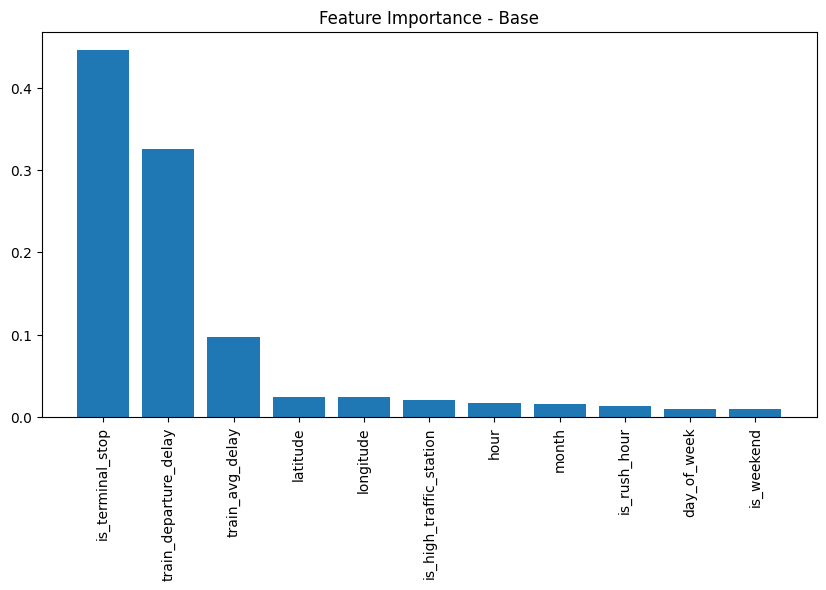

Training on dataset: Graph


[I 2025-03-31 06:59:55,790] A new study created in memory with name: no-name-9534db95-2572-422b-ba00-11c764383f61
[I 2025-03-31 07:00:27,316] Trial 0 finished with value: 5.923875844041637 and parameters: {'eta': 0.2195730412068819, 'max_depth': 5, 'subsample': 0.8264232462403269, 'colsample_bytree': 0.5485733180011674, 'gamma': 0.363480837442661, 'lambda': 1.532589824240082e-08, 'alpha': 0.05015760526285969}. Best is trial 0 with value: 5.923875844041637.
[I 2025-03-31 07:01:23,480] Trial 1 finished with value: 5.923140723669821 and parameters: {'eta': 0.04667919111347974, 'max_depth': 9, 'subsample': 0.8396073300919815, 'colsample_bytree': 0.9356162650237565, 'gamma': 0.5408495898682641, 'lambda': 5.942758924249104e-05, 'alpha': 0.06521932632548037}. Best is trial 1 with value: 5.923140723669821.
[I 2025-03-31 07:01:59,652] Trial 2 finished with value: 5.99404502549464 and parameters: {'eta': 0.018810294717139898, 'max_depth': 4, 'subsample': 0.764640902119249, 'colsample_bytree': 0.

Best parameters for Graph: {'eta': 0.05597961809419918, 'max_depth': 10, 'subsample': 0.7237802825125013, 'colsample_bytree': 0.5313842670890305, 'gamma': 0.42692446198090195, 'lambda': 0.017533286280378733, 'alpha': 0.1202217106139391}
Model saved: models\xgb_graph.pkl
Results saved: results\xgb_results_graph.csv


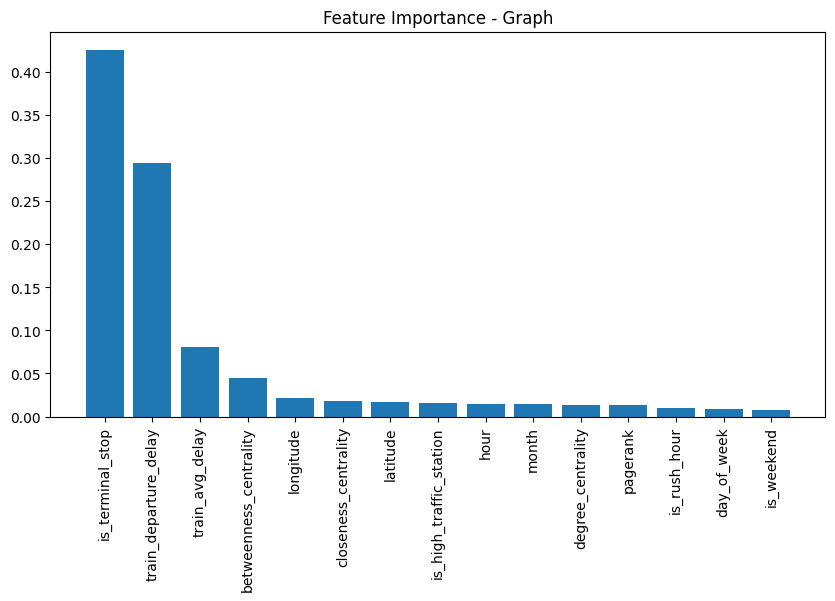

In [4]:
datasets = {
    "Base": pd.read_parquet(PROCESSED_PATH / "final_data.parquet"),
    "Graph": pd.read_parquet(PROCESSED_PATH / "final_data_graph.parquet"),
}

for name, df in datasets.items():
    train_xgboost(name, df)

In [5]:
results_filename = RESULTS_PATH / "xgb_results_base.csv"
results_df = pd.read_csv(results_filename)

print("Results from xgb_results_base:")
print(results_df)

results_filename = RESULTS_PATH / "xgb_results_graph.csv"
results_df = pd.read_csv(results_filename)

print("Results from xgb_results_graph:")
print(results_df)

Results from xgb_results_base:
       RMSE       MAE        R²
0  5.473275  2.551569  0.474788
Results from xgb_results_graph:
      RMSE       MAE        R²
0  5.40942  2.512164  0.486971


In [31]:
df.describe()

,train_departure_delay,stop_arrival_delay,latitude,longitude,hour,day_of_week,is_weekend,month,is_rush_hour,is_high_traffic_station,train_avg_delay
count,2.186827e+07,2.186827e+07,2.186827e+07,2.186827e+07,2.186827e+07,2.186827e+07,2.186827e+07,2.186827e+07,2.186827e+07,2.186827e+07,2.186827e+07
mean,2.732117e+00,3.053886e+00,4.352349e+01,1.140381e+01,1.111157e+01,2.752494e+00,2.242911e-01,6.439963e+00,2.813572e-01,4.670946e-01,3.053886e+00
std,4.825292e+00,7.552311e+00,2.255552e+00,2.361062e+00,5.025524e+00,1.909132e+00,4.171147e-01,3.472697e+00,4.496614e-01,4.989161e-01,2.532760e+00
min,-9.000000e+00,-1.000000e+01,3.673188e+01,6.709959e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+01
25%,1.000000e+00,0.000000e+00,4.189614e+01,9.239260e+00,6.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.498630e+00
50%,2.000000e+00,1.000000e+00,4.433214e+01,1.134227e+01,1.100000e+01,3.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,2.607118e+00
75%,3.000000e+00,4.000000e+00,4.543387e+01,1.277914e+01,1.500000e+01,4.000000e+00,0.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00,4.031311e+00
max,2.890000e+02,2.990000e+02,4.700412e+01,1.816572e+01,2.300000e+01,6.000000e+00,1.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,2.570000e+02


## **Evaluation**  

Contrary to our expectations, the extra graph-based features may not add useful predictive power. In fact, they could be introducing noise rather than improving the model. We will see if this behavior is confirmed by later models.

But leaving out the comparison for a moment, let's analyze the result in general. 

As `df.describe()` shows, the target variable (`stop_arrival_delay`) has the following characteristics:  
- **Mean:** 3.05 
- **Standard deviation:** 7.55  
- **Median (50th percentile):** 1.0  
- **75th percentile:** 4.0  
- **Max:** 299.0

This means that:
- The median delay is just 1 minute, meaning most delays are small (ss already seen in data exploration).  
- The mean is higher than the median, suggesting right-skewed distribution (some extreme delays).  
- The high standard deviation indicates wide variability, likely due to rare but extreme delays.  

In other words, most train delays are characterized by relatively small time variations. The majority of delays are concentrated in the lower range, with occasional extreme outliers. This distribution makes **RMSE** an ideal metric for our model evaluation for several key reasons. In fact, transportation systems prioritize consistency and minimal deviation. By optimizing for RMSE, we minimize frequent, small prediction errors, we reduce the overall variability in delay predictions and we create a model that performs consistently across most scenarios

The graph-enhanced model performs marginally better, with slight improvements in RMSE, MAE, and R^2. However, the difference is not substantial, indicating that the additional graph-based features do not drastically alter the predictive capability of the model. The model still struggles to fully explain the variance in train delays, as reflected by the relatively low R^2 values (~0.47–0.49).  

An RMSE of ~5.4 minutes means that, on average, the model's prediction error is around 5.4 minutes. Given that most delays are between 0 and 4 minutes, this suggests that the model is **not capturing the distribution well**, likely underpredicting larger delays and performing suboptimally on extreme values. This behavior aligns with our concern that the model might be biased toward the mean delay value (~3.05 minutes), reducing its ability to identify outliers effectively.  

## **Train XGB on dataset with Embeddings**

In the initial phase of experimentation, the XGBoost models were trained and evaluated on two datasets: the base dataset and an extended version enriched with handcrafted graph-derived features. Following these experiments, additional LSTM models were developed and tested, including a variant trained on **graph embeddings** generated through a Node2Vec algorithm applied to the railway network graph.

Interestingly, the results showed that the LSTM model trained on graph embeddings outperformed the other LSTM variants, indicating that the embeddings were able to capture relevant structural information from the railway network, beyond what was explicitly encoded in the handcrafted graph features.

Motivated by these findings, we decided to further investigate the contribution of graph embeddings by integrating them into the XGBoost framework. This decision is based on the hypothesis that, given XGBoost's superior performance and lower variance compared to LSTM models, combining it with the additional structural knowledge embedded in the graph embeddings may lead to further improvements in predictive accuracy without compromising efficiency and interpretability.

This experiment aims to assess whether the latent structural relationships learned through the Node2Vec embeddings can enhance XGBoost's predictive capabilities, providing a more informative feature space for the regression task.

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import optuna
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [23]:
PROCESSED_PATH = Path("data/processed")
MODELS_PATH = Path("models")
RESULTS_PATH = Path("results")

Training on dataset: Embeddings


[I 2025-03-31 13:32:30,348] A new study created in memory with name: no-name-04b6b9e4-671a-47ab-9d41-19f48633d071
[I 2025-03-31 13:33:14,499] Trial 0 finished with value: 5.898092507456864 and parameters: {'eta': 0.09465999760602999, 'max_depth': 7, 'subsample': 0.9253650459272693, 'colsample_bytree': 0.9153281896726166, 'gamma': 0.4980223763657654, 'lambda': 0.0001114254231102265, 'alpha': 0.7467250048411963}. Best is trial 0 with value: 5.898092507456864.
[I 2025-03-31 13:33:48,750] Trial 1 finished with value: 5.9143949331135754 and parameters: {'eta': 0.1790194901909898, 'max_depth': 6, 'subsample': 0.7050090858080424, 'colsample_bytree': 0.6454311458628934, 'gamma': 0.11388035684942521, 'lambda': 1.0476959820884625e-07, 'alpha': 7.51868072704627e-05}. Best is trial 0 with value: 5.898092507456864.
[I 2025-03-31 13:34:29,037] Trial 2 finished with value: 5.923379858060238 and parameters: {'eta': 0.2709777306020361, 'max_depth': 4, 'subsample': 0.9787745828116388, 'colsample_bytree'

Best parameters for Embeddings: {'eta': 0.09465999760602999, 'max_depth': 7, 'subsample': 0.9253650459272693, 'colsample_bytree': 0.9153281896726166, 'gamma': 0.4980223763657654, 'lambda': 0.0001114254231102265, 'alpha': 0.7467250048411963}
Model saved: models\xgb_embeddings.pkl
Results saved: results\xgb_results_embeddings.csv


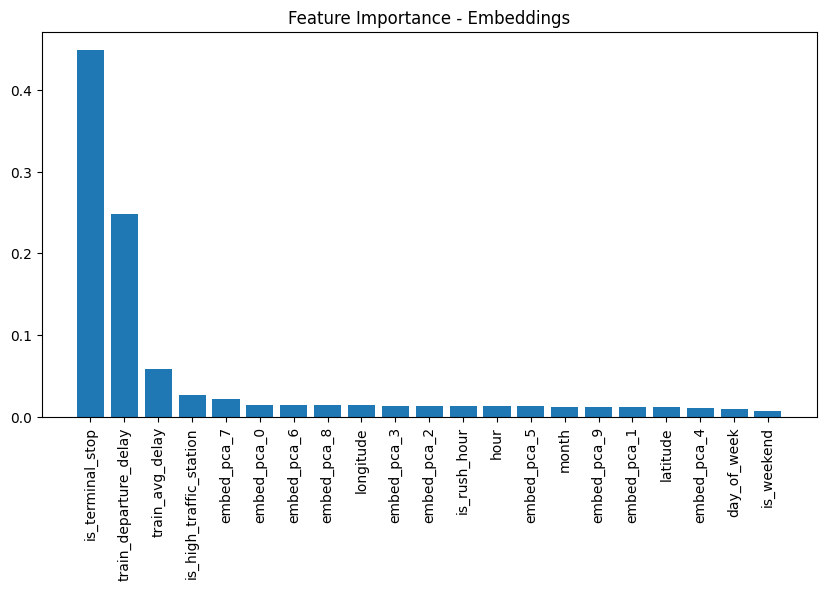

In [30]:
dataset_name = "Embeddings"
df = pd.read_parquet(PROCESSED_PATH / "final_data_embeddings.parquet")
train_xgboost(dataset_name, df)

Evaluation embeddings

In [19]:
results_filename = RESULTS_PATH / "xgb_results_embeddings.csv"
results_df = pd.read_csv(results_filename)

print("Results from xgb_results_embeddings:")
print(results_df)

Results from xgb_results_embeddings:
       RMSE       MAE        R²
0  5.436703  2.502389  0.481783


**Impact of Embeddings on Model Performance**  

After integrating embeddings into the base dataset, we observe only marginal differences in predictive performance. The RMSE and R^2 values remain similar to the previous models, while the MAE slightly improves. This suggests that the embeddings may capture some useful latent information, but not enough to significantly enhance the model’s overall accuracy.  

In particular, the RMSE of **5.437** minutes is almost identical to the results obtained with the graph-based dataset (5.409), while the MAE of **2.502** minutes is the lowest recorded so far. This indicates that the model is making slightly more accurate short-delay predictions but still struggles with large, rare delays.  

These results reinforce the idea that most train delays are predictable within a small range, and additional features may not necessarily improve the model’s ability to capture extreme variations.